In [11]:
import dac
from dac.model.dac import EncoderBlock, DecoderBlock, ResidualUnit
from dac.nn.layers import Snake1d
from audiotools import AudioSignal
import torch
from torch import nn
import copy
import matplotlib.pyplot as plt

In [3]:
model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)
print("done loading")

[codebook size] 1024
[# codebooks] 9
[ignore left crop] False
[encoder causal] False
[encoder frame indep] False
[decoder causal] False
[decoder frame indep] False
[# trainable params] 76651890
[# trainable params (enc)] 22307968
[# trainable params (dec)] 54104162
done loading


In [4]:
model.eval()

DAC(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (1): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (2): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
              (2): Snake1d()
              

IndexError: index 16 is out of bounds for axis 0 with size 16

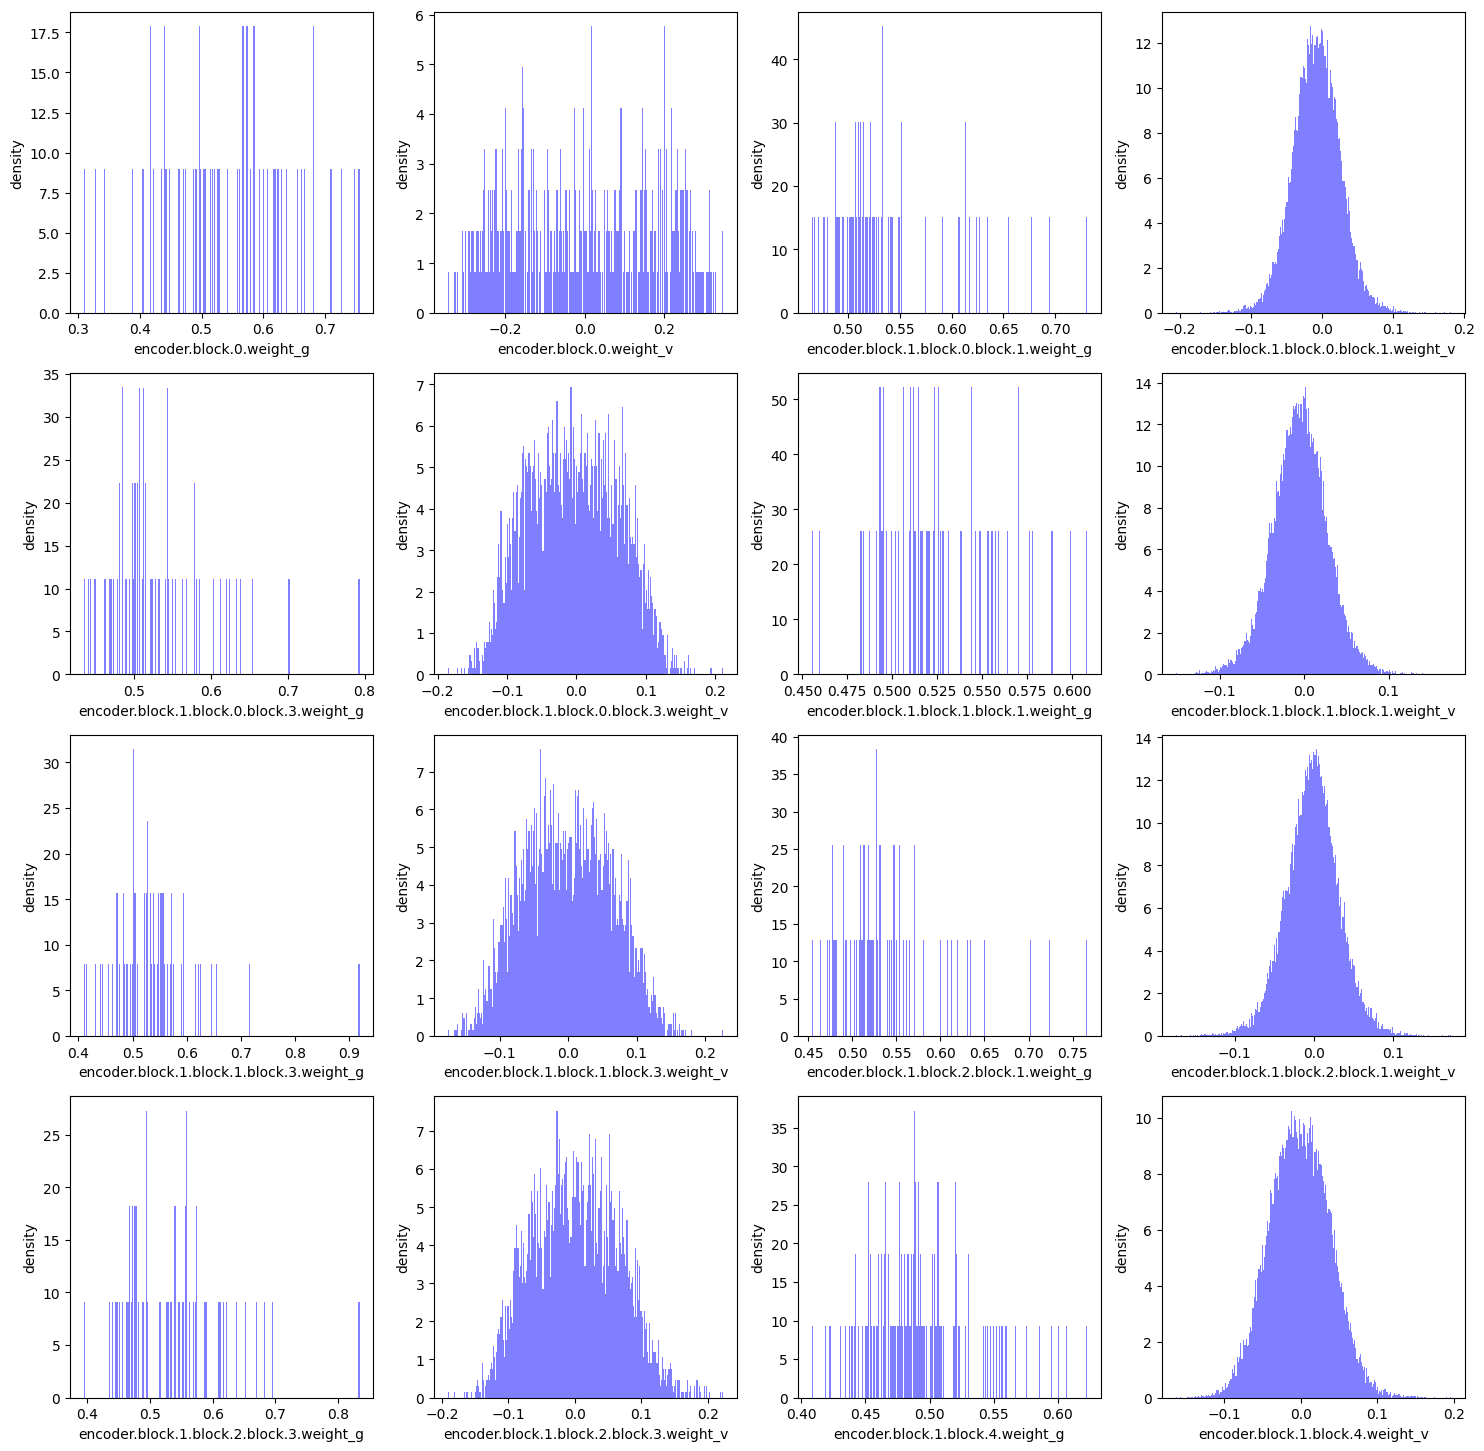

In [18]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(4, 4, figsize=(18, 18))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1 and 'weight' in name:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

# recover_model()
plot_weight_distribution(model)

In [8]:
weight_bitwidth = 8
feature_bitwidth = 8

def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: scale the fp_tensor
    scaled_tensor = fp_tensor / scale
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)
    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point
    ############### YOUR CODE ENDS HERE #################

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code
    bias_scale = input_scale * weight_scale
    ############### YOUR CODE ENDS HERE #################

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    ############### YOUR CODE STARTS HERE ###############
    # hint: this code block should be the very similar to quantized_linear()

    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc, height, width]
    output = output.float()
    output *= (input_scale * weight_scale.flatten().view(1, -1, 1, 1) / output_scale)

    # Step 3: shift output by output_zero_point
    #         hint: one line of code
    output = output + output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

class QuantizedConv1d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )


In [ ]:
quantized_model = copy.deepcopy(model_fused)


# ## GO THROUGH CONV LAYERS 
# conv_layers = []

# for idx, layer in enumerate(model.encoder.block):
#     print(idx, layer)
#     if isinstance(layer, nn.Conv1d):
#         print("nn.Conv1d here")
#         conv_layers.append(layer)
#     elif isinstance(layer, EncoderBlock):
#         encoder_block_layers = layer.block
#         print("encoder block here")
#         for encoder_block_layer in encoder_block_layers:
#             if isinstance(encoder_block_layer, nn.Conv1d):
#                 print("nn.Conv1d here")
#                 conv_layers.append(encoder_block_layer)
#             elif isinstance(encoder_block_layer, ResidualUnit):
#                 residual_unit_layers = encoder_block_layer.block
#                 print("residual unit here")
#                 for residual_unit_layer in residual_unit_layers:
#                     if isinstance(residual_unit_layer, nn.Conv1d):
#                         print("nn.Conv1d here")
#                         conv_layers.append(residual_unit_layer)

In [ ]:
# conv_layers = []

# for idx, layer in enumerate(model.decoder.model):
#     print(idx, layer)
#     if isinstance(layer, nn.Conv1d):
#         print("nn.Conv1d here")
#         conv_layers.append(layer)
#     elif isinstance(layer, DecoderBlock):
#         decoder_block_layers = layer.block
#         print("encoder block here")
#         for decoder_block_layer in decoder_block_layers:
#             if isinstance(decoder_block_layer, nn.Conv1d):
#                 print("nn.Conv1d here")
#                 conv_layers.append(decoder_block_layer)
#             elif isinstance(decoder_block_layer, ResidualUnit):
#                 residual_unit_layers = decoder_block_layer.block
#                 print("residual unit here")
#                 for residual_unit_layer in residual_unit_layers:
#                     if isinstance(residual_unit_layer, nn.Conv1d):
#                         print("nn.Conv1d here")
#                         conv_layers.append(residual_unit_layer)

# conv_layers

In [ ]:
def find_conv_layers(layers, conv_layers):
    for layer in layers:
        if isinstance(layer, (nn.Conv1d, nn.ConvTranspose1d)):
            conv_layers.append(layer)
        elif hasattr(layer, 'block'):
            find_conv_layers(layer.block, conv_layers)

encoder_conv_layers = []
decoder_conv_layers = []

find_conv_layers(model.encoder.block, encoder_conv_layers)
find_conv_layers(model.decoder.model, decoder_conv_layers)

encoder_conv_layers, decoder_conv_layers

In [8]:
audio_file_path = "f1_script1_iphone_balcony1.wav"
signal = AudioSignal(audio_file_path)

signal = signal.cpu()
print(signal.shape)
# x = model.compress(signal)

# # Save and load to and from disk
# x.save("compressed.dac")
# x = dac.DACFile.load("compressed.dac")

# # Decompress it back to an AudioSignal
# y = model.decompress(x)



torch.Size([1, 1, 7539712])


In [5]:
# model.qconfig = torch.ao.quantization.get_default_qconfig('x86')

In [6]:
# model_fp32_prepared = model # torch.ao.quantization.prepare(model)
# input_fp32 = torch.randn(1, 1, 7539)
# model_fp32_prepared(input_fp32)


{'audio': tensor([[[-0.1373, -0.1210, -0.3083,  ..., -0.0587,  0.1481,  0.2086]]],
        grad_fn=<SliceBackward0>),
 'z': tensor([[[-2.7376, -5.9216,  0.1534,  ...,  0.0890, -1.9257, -3.3301],
          [ 3.7167, -0.2829, -2.7268,  ...,  7.0995,  2.1479, -0.1615],
          [ 4.7342, -6.3042, -4.4666,  ...,  1.9308, -3.1288,  1.8012],
          ...,
          [-0.4077,  2.9430, -6.8092,  ..., -2.7056,  1.0259, -6.5504],
          [-5.8558, -3.9825,  0.2893,  ..., -3.9748, -5.7457, -5.4240],
          [ 3.6048,  5.4514, -2.6522,  ..., -5.2044, -0.1594, -0.8426]]],
        grad_fn=<AddBackward0>),
 'codes': tensor([[[ 252,  329,  581, 1003,  207,  699,  387,  849,  123,  913,  790,
            160,  160,  807,  550],
          [  65,   47,  776,  530,  529, 1009,  942,  168,  234,  480,  132,
            799,  340,  761,  766],
          [ 769,  749,   80,  139,   70,  973,  956,  652,  829,  313,  891,
            891,  486,  121,  156],
          [ 808,  790,  918,  727,  189,  683, 

In [7]:
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [3]:
# Quantization 
import torch
import torch_tensorrt

# from torch.quantization import quantize_dynamic, quantize_static, prepare, convert

# Stuff to try
# 1. Linear quantization r = S(q-z)
# 2. AWQ (activation-aware weight quantization)

ModuleNotFoundError: No module named 'torch_tensorrt'

In [8]:


##########SAVE##############
# Save and load to and from disk
x.save("compressed.dac")
x = dac.DACFile.load("compressed.dac")

# Decompress it back to an AudioSignal
y = model.decompress(x)

# Write to file
y.write('output.wav')

#################################


/home/gridsan/awang2/.local/lib/python3.9/site-packages/audiotools/core/audio_signal.py:501: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(
/home/gridsan/awang2/.local/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 